# Digit Sequences

### Recognizing digit sequences from the original SVHN dataset using TensorFlow

---

The following notebook details my implementation of a Convolutional Neural Network to recognize sequences of digits in natural images taken from the SVHN dataset. I have broken the notebook into two parts as TensorFlow programs are usually structured into a **construction phase**, that assembles a graph, and an **execution phase** that uses a session to execute ops in the graph.

Let's start by importing some libraries and load our dataset.

In [46]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import time
import os
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

print("Tensorflow version: " + tf.__version__)

Tensorflow version: 2.0.0


## Loading the data

Let's load the greyscale images created in our previous notebook

In [47]:
# Open the HDF5 file containing the datasets
h5f = h5py.File('SVHN_multi_grey.h5','r')

# Extract the datasets
X_train = h5f['train_dataset'][:]
y_train = h5f['train_labels'][:]
X_val = h5f['valid_dataset'][:]
y_val = h5f['valid_labels'][:]
X_test = h5f['test_dataset'][:]
y_test = h5f['test_labels'][:]

# Close the file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (30401, 32, 32, 1) (30401, 5)
Validation set (3000, 32, 32, 1) (3000, 5)
Test set (13068, 32, 32, 1) (13068, 5)


Keep the data dimensions as they will be reused multiple times in the following code

In [48]:
X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])

print('Training set', X_train.shape, y_train.shape)

Training set (33401, 32, 32, 1) (33401, 5)


Let's shuffle the training set using ``sklearn.utils.shuffle``

In [49]:
from sklearn.utils import shuffle

# Randomly shuffle the training data
X_train, y_train = shuffle(X_train, y_train)

### Data Preprocessing

Mean subtraction is the most common form of preprocessing. It involves subtracting the mean across every individual feature in the data, and has the geometric interpretation of centering the cloud of data around the origin along every dimension. [``Goodfellow et al.``](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf) (96.03%) and [``Ba et al.``](https://arxiv.org/pdf/1412.7755.pdf) (96.1%) both preprocess the images by subtracting the mean of every image.

In [51]:
def subtract_mean(a):
    """ Helper function for subtracting the mean of every image
    """
    for i in range(a.shape[0]):
        a[i] -= a[i].mean()
    return a


# Subtract the mean from every image
X_train = subtract_mean(X_train)
X_test = subtract_mean(X_test)
X_val = subtract_mean(X_val)

## Helper functions

Let's implement some helper functions to make our notebook easier to read and reduce code duplication.

### Helper function for plotting images

Here is a simple helper function that will help us plot ``nrows`` * ``ncols`` images and their true and predicted labels.

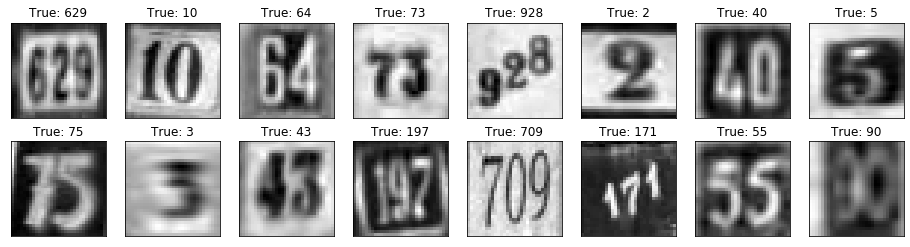

In [52]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    
    # Initialize figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        
        # Pretty string with actual number
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        
        if cls_pred is None:
            title = "True: {0}".format(true_number)
        else:
            # Pretty string with predicted number
            pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
            title = "True: {0}, Pred: {1}".format(true_number, pred_number) 
            
        ax.imshow(images[i,:,:,0], cmap='binary')
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])
        
        
# Plot some images from the training set
plot_images(X_train, 2, 8, y_train)

In [11]:
# import the necessary packages
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import keras

Using TensorFlow backend.


In [19]:
x1 = Input(shape=(32,32,1))
x = Conv2D(16, (5, 5), padding="same")(x1)
x = Activation("relu")(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(32, (5, 5), padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (5, 5), padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization(axis=-1)(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(64)(x)
x = Activation("relu")(x)
a = Dense(11, activation = 'softmax')(x)
b = Dense(11, activation = 'softmax')(x)
c = Dense(11, activation = 'softmax')(x)
d = Dense(11, activation = 'softmax')(x)
e = Dense(11, activation = 'softmax')(x)
model  = Model(
    inputs=x1,
    outputs=[a,b,c,d,e],
)

In [13]:
y_train = keras.utils.to_categorical(y_train, num_classes = 11)
y_val = keras.utils.to_categorical(y_val, num_classes = 11)
y_test = keras.utils.to_categorical(y_test, num_classes = 11)
print(y_train.shape)
print(y_train[0][:][:])

(33401, 5, 11)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [32]:
#model.summary()
print(y_val.shape)
print(X_train.shape)
y = np.ndarray(shape=(5,33401,11))
for i in range(y_train.shape[0]):
    for j in range(y_train.shape[1]):
        y[j][i] = y_train[i][j]
yval = np.ndarray(shape=(5,3000,11))
for i in range(y_val.shape[0]):
    for j in range(y_val.shape[1]):
        yval[j][i] = y_val[i][j]
ytest = np.ndarray(shape=(5,13068,11))
for i in range(y_test.shape[0]):
    for j in range(y_test.shape[1]):
        ytest[j][i] = y_test[i][j]
print(y.shape,yval.shape,ytest.shape)

(3000, 5, 11)
(33401, 32, 32, 1)
(5, 33401, 11) (5, 3000, 11) (5, 13068, 11)


In [29]:
yval[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [21]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3), loss=[
    keras.losses.CategoricalCrossentropy(),
    keras.losses.CategoricalCrossentropy(),
    keras.losses.CategoricalCrossentropy(),
    keras.losses.CategoricalCrossentropy(),
    keras.losses.CategoricalCrossentropy(),
    ], metrics=['accuracy','accuracy','accuracy','accuracy','accuracy'])


In [22]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 32, 32, 16)   416         input_3[0][0]                    
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 32, 32, 16)   0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 32, 32, 16)   64          activation_9[0][0]               
____________________________________________________________________________________________

In [33]:
model.fit(x=X_train,y=[y[0],y[1],y[2],y[3],y[4]],epochs = 20,batch_size=64, validation_data=(X_val,[yval[0],yval[1],yval[2],yval[3],yval[4]]))

Train on 33401 samples, validate on 3000 samples
Epoch 1/20
33401/33401 [==============================] - 115s 3ms/step - loss: 3.4808 - dense_8_loss: 1.0508 - dense_9_loss: 1.3642 - dense_10_loss: 0.8363 - dense_11_loss: 0.2142 - dense_12_loss: 0.0151 - dense_8_accuracy: 0.6697 - dense_9_accuracy: 0.5619 - dense_10_accuracy: 0.7509 - dense_11_accuracy: 0.9543 - dense_12_accuracy: 0.9978 - val_loss: 2.0857 - val_dense_8_loss: 0.5753 - val_dense_9_loss: 0.8403 - val_dense_10_loss: 0.5186 - val_dense_11_loss: 0.1461 - val_dense_12_loss: 0.0056 - val_dense_8_accuracy: 0.8200 - val_dense_9_accuracy: 0.7457 - val_dense_10_accuracy: 0.8333 - val_dense_11_accuracy: 0.9643 - val_dense_12_accuracy: 0.9997
Epoch 2/20
33401/33401 [==============================] - 115s 3ms/step - loss: 2.0016 - dense_8_loss: 0.5738 - dense_9_loss: 0.7748 - dense_10_loss: 0.5052 - dense_11_loss: 0.1434 - dense_12_loss: 0.0043 - dense_8_accuracy: 0.8219 - dense_9_accuracy: 0.7514 - dense_10_accuracy: 0.8427 - dens

33401/33401 [==============================] - 115s 3ms/step - loss: 0.5895 - dense_8_loss: 0.1705 - dense_9_loss: 0.2259 - dense_10_loss: 0.1457 - dense_11_loss: 0.0447 - dense_12_loss: 0.0027 - dense_8_accuracy: 0.9447 - dense_9_accuracy: 0.9255 - dense_10_accuracy: 0.9529 - dense_11_accuracy: 0.9860 - dense_12_accuracy: 0.9997 - val_loss: 0.3194 - val_dense_8_loss: 0.0955 - val_dense_9_loss: 0.1169 - val_dense_10_loss: 0.0768 - val_dense_11_loss: 0.0289 - val_dense_12_loss: 0.0016 - val_dense_8_accuracy: 0.9703 - val_dense_9_accuracy: 0.9660 - val_dense_10_accuracy: 0.9730 - val_dense_11_accuracy: 0.9910 - val_dense_12_accuracy: 0.99972201 - dense_10_loss: 0.1453 - dense_11_loss: 0.0448 - dense_12_loss: 0.0032 - dense_8_accuracy: 0.9455 - dense_9_accuracy: 0.9274 - dense_10_accuracy: 0.9529 - dense_11_accuracy: 0.9863 - dense - ETA: 13s - loss: 0.5858 - dense_8_loss: 0.1697 - dense_9_loss: 0.2217 - dense_10_loss: 0.1463 - dense_11_loss: 0.0449 - dense_12_loss: 0.0031 - dense_8_accur

In [34]:
score = model.evaluate(x=X_test,y=[ytest[0],ytest[1],ytest[2],ytest[3],ytest[4]])

13068/13068 [==============================] - 24s 2ms/step


In [40]:
accuracy =0;
print('------------------------------------------------------------------------')
for i in range(6,11):
    accuracy += score[i]
    print('Accuracy for ',(i-5),'digit\'s position is: ',score[i]*100,"%")
print('------------------------------------------------------------------------')
print('Overall accuracy of model for all five positions is: ',accuracy/5*100,'%')

------------------------------------------------------------------------
Accuracy for  1 digit's position is:  85.33822894096375 %
Accuracy for  2 digit's position is:  81.8640947341919 %
Accuracy for  3 digit's position is:  91.57484173774719 %
Accuracy for  4 digit's position is:  99.06642436981201 %
Accuracy for  5 digit's position is:  99.98469352722168 %
------------------------------------------------------------------------
Overall accuracy of model for all five positions is:  91.5656566619873 %


In [42]:
eg = np.zeros(shape=(500,32,32,1))
for i in range(500):
    eg[i] = X_test[i]
arr = model.predict(eg)

In [43]:
yhash = np.ndarray(shape = (500,5,11))
for i in range(500):
    for j in range(5):
        yhash[i][j] = arr[j][i]
print(yhash[0][1])

yactual = np.ndarray(shape = (500,5,11))
for i in range(500):
    for j in range(5):
        yactual[i][j] = ytest[j][i]
print(yactual[0][1])

[2.59534521e-16 3.19545923e-09 1.70341756e-19 2.25400920e-10
 2.38491034e-19 2.19313057e-11 7.34826546e-16 1.84868024e-10
 2.52050983e-23 2.37387535e-17 1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [44]:
# Helper function to convert categorical data to numerical data
def num(a):
    number = np.argmax(a[0])
    for i in range(4):
        if np.argmax(a[i+1])< 10:
            number = number*10
            number = number + np.argmax(a[i+1])
    return number

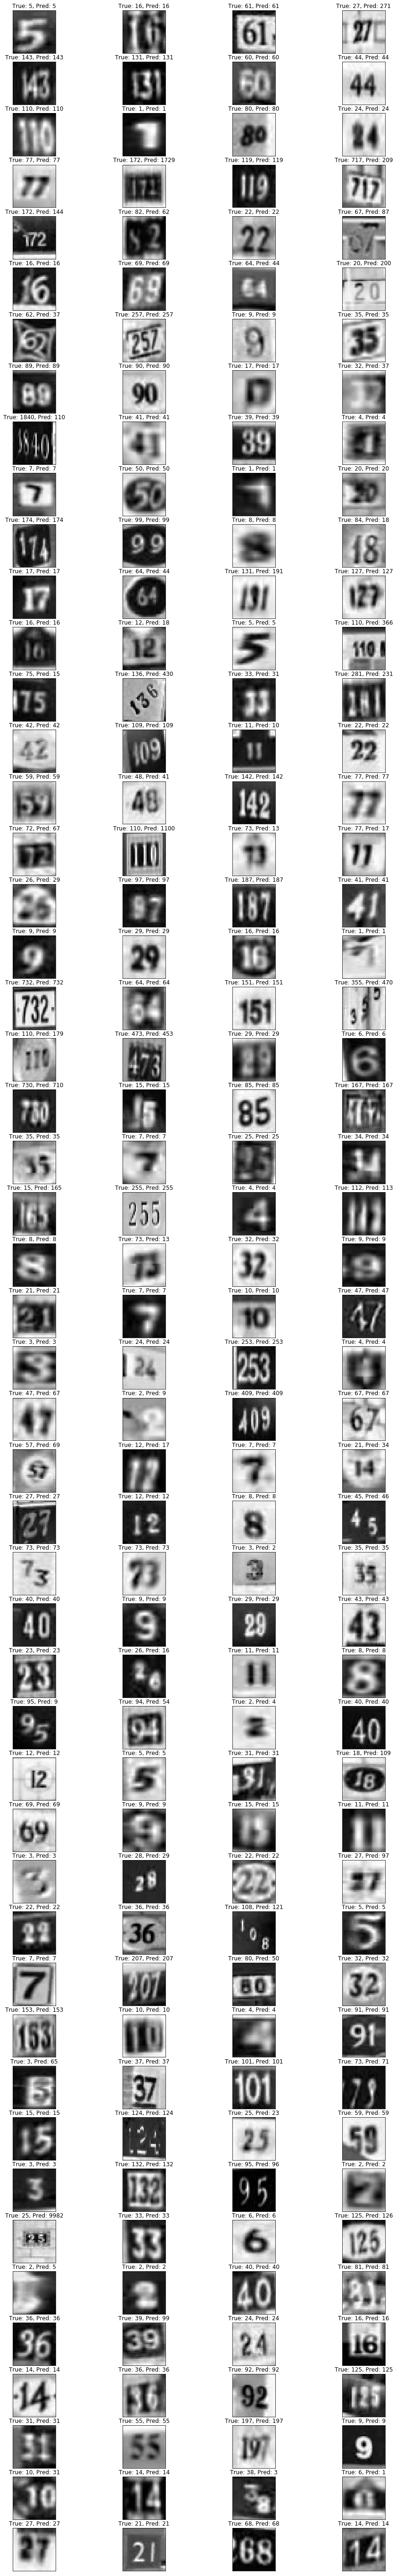

In [45]:
fig, axes = plt.subplots(50, 4, figsize=(16, 2*50))

for i, ax in enumerate(axes.flat): 
        
        true_number = num(y_test[i][:])
        pred_number = num(yhash[i][:])
        title = "True: {0}, Pred: {1}".format(true_number, pred_number) 
            
        ax.imshow(eg[i,:,:,0], cmap='binary')
        ax.set_title(title)   
        ax.set_xticks([]);
        ax.set_yticks([])

In [60]:
model_json = model.to_json()
with open("svhnmodel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("svhnmodel.h5")
print("Saved model to disk")

Saved model to disk


In [57]:
# load json and create model
from keras.models import model_from_json
json_file = open('svhnmodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("svhnmodel.h5")
print("Loaded model from disk")

Loaded model from disk


In [59]:
loaded_model.compile(optimizer=keras.optimizers.RMSprop(1e-3), loss=[
    keras.losses.CategoricalCrossentropy(),
    keras.losses.CategoricalCrossentropy(),
    keras.losses.CategoricalCrossentropy(),
    keras.losses.CategoricalCrossentropy(),
    keras.losses.CategoricalCrossentropy(),
    ], metrics=['accuracy','accuracy','accuracy','accuracy','accuracy'])
loaded_model.evaluate(x=X_test,y=[ytest[0],ytest[1],ytest[2],ytest[3],ytest[4]])

13068/13068 [==============================] - 27s 2ms/step


[2.215755421778898,
 0.7678629159927368,
 0.9619332551956177,
 0.43147778511047363,
 0.05090034008026123,
 0.004978286102414131,
 0.8533822894096375,
 0.818640947341919,
 0.9157484173774719,
 0.9906642436981201,
 0.9998469352722168]